# 1. Set up the Notebook Environment

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preproc
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model


# 2. Prepare the Dataset

In [3]:
DATASET_PATH = "/kaggle/input/dog-breed-identification"
train_dir = os.path.join(DATASET_PATH, "train")
labels_csv = os.path.join(DATASET_PATH, "labels.csv")

df = pd.read_csv(labels_csv)
print("Number of training images:", len(df))
df.head()

# Create a column 'file_path' in df, pointing to the actual image file
df['file_path'] = df['id'].apply(lambda x: os.path.join(train_dir, x + ".jpg"))

# Number of unique breeds
dog_breeds = sorted(df['breed'].unique())
num_classes = len(dog_breeds)
print("Unique breeds:", num_classes)

# Train/Validation split
train_df, val_df = train_test_split(
    df, 
    test_size=0.2, 
    random_state=42, 
    stratify=df['breed']
)

print(f"Train split size: {len(train_df)}, Val split size: {len(val_df)}")


Number of training images: 10222
Unique breeds: 120
Train split size: 8177, Val split size: 2045


# 2.2 Create a mapping from breed to integer label

In [4]:
breed_to_idx = {breed: idx for idx, breed in enumerate(dog_breeds)}

train_df['label_idx'] = train_df['breed'].map(breed_to_idx)
val_df['label_idx'] = val_df['breed'].map(breed_to_idx)


# 3. Create an ImageDataGenerator

In [5]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data augmentation for training
train_datagen = ImageDataGenerator(
    preprocessing_function=mobilenet_preproc,  # Rescale to [-1,1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No augmentation for validation
val_datagen = ImageDataGenerator(preprocessing_function=mobilenet_preproc)

# Flow from dataframe
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',
    y_col='breed',  # We can pass the breed name and 'class_mode="categorical"'
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='file_path',
    y_col='breed',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 8177 validated image filenames belonging to 120 classes.
Found 2045 validated image filenames belonging to 120 classes.


# 4. Build the Transfer Learning Model (MobileNetV2)

In [6]:
# 4.1 Load the base model (MobileNetV2)
base_model = MobileNetV2(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    include_top=False,
    weights='imagenet'
)

# 4.2 Freeze the base model's layers
for layer in base_model.layers:
    layer.trainable = False

# 4.3 Add our custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,411,704 (9.20 MB)

 Trainable params: 153,720 (600.47 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# 5. Train the Model

Calculated steps_per_epoch: 255
Calculated validation_steps: 63
Epoch 1/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 95s 363ms/step - accuracy: 0.8493 - loss: 0.4477 - val_accuracy: 0.7852 - val_loss: 0.7270
Epoch 2/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 182us/step - accuracy: 0.8750 - loss: 0.3688 - val_accuracy: 0.7931 - val_loss: 0.7292
Epoch 3/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 96s 367ms/step - accuracy: 0.8570 - loss: 0.4257 - val_accuracy: 0.7897 - val_loss: 0.7277
Epoch 4/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.8438 - loss: 0.6351 - val_accuracy: 0.7241 - val_loss: 0.7245
Epoch 5/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 95s 365ms/step - accuracy: 0.8518 - loss: 0.4503 - val_accuracy: 0.7897 - val_loss: 0.7325
Epoch 6/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 191us/step - accuracy: 0.7500 - loss: 0.7393 - val_accuracy: 0.8276 - val_loss: 0.7400
Epoch 7/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 96s 365ms/step - accuracy: 0.8568 - loss: 0.4321 - val_accuracy: 0.7808 - val_loss: 0.7504
Epoch 8/100
255

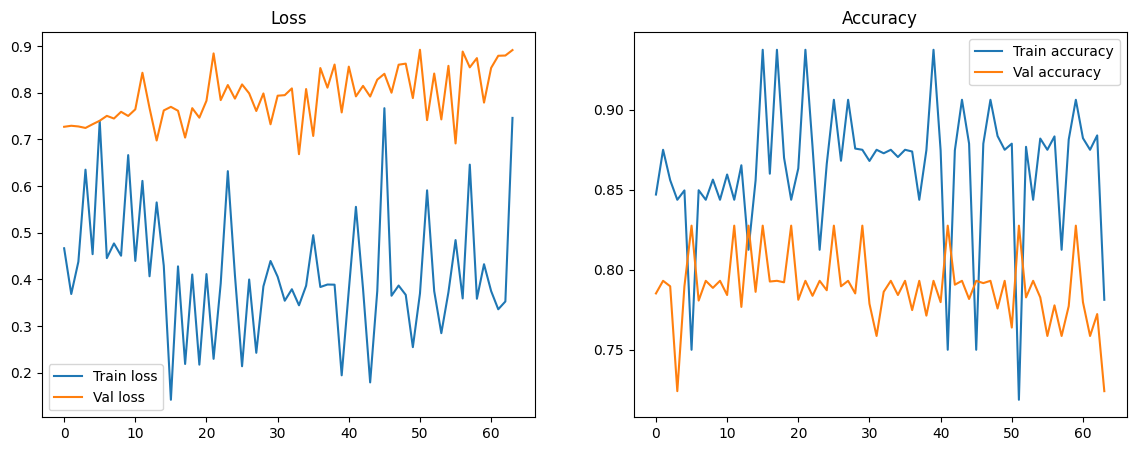

In [9]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

EPOCHS = 40

# Calculate the correct number of steps for training & validation
STEPS_PER_EPOCH = train_gen.samples // train_gen.batch_size
VAL_STEPS       = val_gen.samples   // val_gen.batch_size

print("Calculated steps_per_epoch:", STEPS_PER_EPOCH)
print("Calculated validation_steps:", VAL_STEPS)

# EarlyStopping callback: if val_loss doesn’t improve for `patience` epochs, stop training
early_stopping_cb = EarlyStopping(
    monitor='val_loss',
    patience=30,            # Adjust patience based on your preference
    restore_best_weights=True,
    verbose=1
)

# Train the model with early stopping
history = model.fit(
    train_gen,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=val_gen,
    validation_steps=VAL_STEPS,
    epochs=EPOCHS,
    callbacks=[early_stopping_cb],
    verbose=1
)

# Evaluate model performance
val_loss, val_acc = model.evaluate(val_gen, steps=VAL_STEPS)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

# Plot training history
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()


# 6. Evaluate and Save as .h5

In [10]:
val_loss, val_acc = model.evaluate(val_gen, steps=VAL_STEPS)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

model.save("dog_breed_classifier_mobilenetv2.h5")
print("Keras model saved as dog_breed_classifier_mobilenetv2.h5")


63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.7783 - loss: 0.8270
Validation Loss: 0.8098, Validation Accuracy: 0.7867
Keras model saved as dog_breed_classifier_mobilenetv2.h5


# 7. Convert to TFLite

In [11]:
# Convert the Keras model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("dog_breed_classifier_mobilenetv2.tflite", "wb") as f:
    f.write(tflite_model)

print("TFLite model saved as dog_breed_classifier_mobilenetv2.tflite")


Saved artifact at '/tmp/tmptbnuk_79'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 120), dtype=tf.float32, name=None)
Captures:
  134359311366480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134359306009264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134359304176384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134359306010320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134359306009792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134359304180784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134359304180432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134359304184128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134359304181488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134359304182368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134359304187

# 8. Testing the TFLite Model Inside Kaggle 

In [12]:
# Let's pick one validation image
sample_row = val_df.iloc[0]
sample_img_path = sample_row['file_path']
sample_breed = sample_row['breed']

# 8.1 Load and preprocess
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def preprocess_mobilenet(img_path, target_size=(224,224)):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    # Scale pixel values to [-1,1]
    img_array = mobilenet_preproc(img_array)
    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

test_input = preprocess_mobilenet(sample_img_path)

# 8.2 TFLite inference
interpreter = tf.lite.Interpreter(model_path="dog_breed_classifier_mobilenetv2.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.set_tensor(input_details[0]['index'], test_input)
interpreter.invoke()
tflite_output = interpreter.get_tensor(output_details[0]['index'])[0]  # shape (120,)

# 8.3 Keras model inference
keras_output = model.predict(test_input)[0]

# Compare indices
print("TFLite predicted index:", np.argmax(tflite_output))
print("Keras predicted index:", np.argmax(keras_output))

print("Actual label/breed:", sample_breed)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
TFLite predicted index: 118
Keras predicted index: 118
Actual label/breed: lakeland_terrier
